In [ ]:
# TODO

# load the test dataset with evecs
# think how to have shapes/poses not present in training set

# put conditional generation in a separate notebook
# put the functions to .py file

# get the p2p map from fmap and calculate the geodesic error
# evaluate 2 types of conditional diffusion

In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [2]:
import sys
sys.path.append('/home/s94zalek/shape_matching')

from my_code.datasets.surreal_cached_train_dataset import SurrealTrainDataset


full_dataset = SurrealTrainDataset('/home/s94zalek/shape_matching/data/SURREAL_full/incomplete_datasets/125_125_250_0_28')

# select 90% of the dataset for training and 10% for validation
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size

print(f'Training dataset size: {train_size}', f'Validation dataset size: {val_size}')

train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True)

train_dataset[0][0].shape, train_dataset[0][1].shape

Fmap dim: 28
Training dataset size: 56250 Validation dataset size: 6250


(torch.Size([1, 28, 28]), torch.Size([1, 28]))

In [3]:
class DiagConditionedUnet(nn.Module):
  def __init__(self):
    super().__init__()

    # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
    self.model = UNet2DModel(
        sample_size=28,           # the target image resolution
        in_channels=2, # Additional input channels for class cond.
        out_channels=1,           # the number of output channels
        layers_per_block=2,       # how many ResNet layers to use per UNet block
        block_out_channels=(32, 64, 64),
        down_block_types=(
            "DownBlock2D",        # a regular ResNet downsampling block
            "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ),
        up_block_types=(
            "AttnUpBlock2D",
            "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",          # a regular ResNet upsampling block
          ),
    )

  # Our forward method now takes the class labels as an additional argument
  def forward(self, sample, timestep, conditioning):

    conditioning_diag = torch.diag_embed(conditioning) # (bs, 28, 28

    # Net input is now x and class cond concatenated together along dimension 1
    net_input = torch.cat((sample, conditioning_diag), 1) # (bs, 5, 28, 28)

    # Feed this to the UNet alongside the timestep and return the prediction
    return self.model(net_input, timestep) # (bs, 1, 28, 28)


  0%|          | 0/25 [00:00<?, ?it/s]

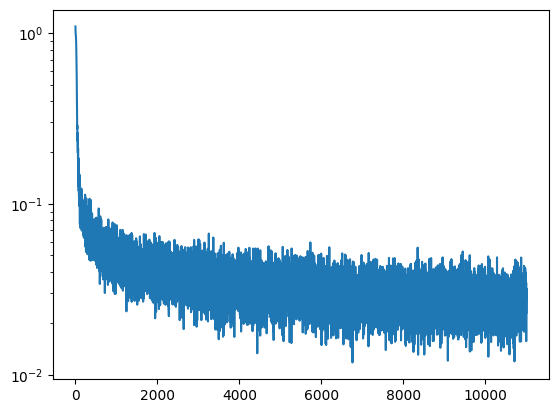

In [4]:
import my_code.diffusion_training.train_model as train_model

model_diag_conditional = DiagConditionedUnet().to(device)

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2',
                                clip_sample=True)


model_diag_conditional, losses_diag_cond = train_model.train(
    model=model_diag_conditional, n_epochs=25, loss_fn=nn.MSELoss(), is_unconditional=False,
    train_dataloader=train_dataloader, noise_scheduler=noise_scheduler
    )

plt.plot(losses_diag_cond)
plt.yscale('log')

plt.show()
  

In [5]:
from diffusers import UNet2DConditionModel

class EncoderConditionedUnet(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = UNet2DConditionModel(
            sample_size=28,           # the target image resolution
            in_channels=1, # Additional input channels for class cond.
            out_channels=1,           # the number of output channels
            layers_per_block=2,       # how many ResNet layers to use per UNet block
            block_out_channels=(32, 64, 64),
            down_block_types=(
                "DownBlock2D",        # a regular ResNet downsampling block
                "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
                "AttnDownBlock2D",
            ),
            up_block_types=(
                "AttnUpBlock2D",
                "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
                "UpBlock2D",          # a regular ResNet upsampling block
              ),
            encoder_hid_dim=28,
        ).to(device)
    
  def forward(self, sample, timestep, conditioning):
    return self.model(sample, timestep, encoder_hidden_states=conditioning)

model_encoder_conditional = EncoderConditionedUnet().to(device)

model_encoder_conditional, losses_encoder_cond = train_model(
    model=model_encoder_conditional, n_epochs=25, loss_fn=nn.MSELoss(), is_unconditional=False
    )

plt.plot(losses_encoder_cond)
plt.yscale('log')

plt.show()

TypeError: 'module' object is not callable